# Calculate crop statistics 

## Background

Crop type maps provide information on the distribution of different crops and can be used to generate crop area statistics, contributing to the understanding of agricultural production.

## Description

This notebook demonstrates how to calculate crop area statistics using the crop type maps and input administration boundaries vector file.
Results are inspected and saved into tables.


## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
import os
import pickle
import json

import datacube
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
from deafrica_tools.spatial import xr_rasterize

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


## Load admin boundaries and crop map

We will load the data using coordinate reference system `EPSG:6933` for area calculation. The reference system uses units in meter.

In [2]:
output_crs = "EPSG:6933"

Geometries for regions where crop areas are to be calculated are loaded in a GeoPandas Dataframe. For calculating crop areas within the entire country, one geometry for the country should be provided. For calculating crop areas within provinces, a list of geometries for the provinces should be provided.

> For testing, we caculate crop areas for level 3 admin regions within a district where a crop type map has been generated.

In [3]:
# select the district name for which a crop map is available
district_name = "Nhamatanda" 
district_name = "Lichinga"

mozambique_admins = gpd.read_file("Data/Mozambique_admin_gadm_level3.geojson")
area_of_interest_gdf = mozambique_admins[mozambique_admins["NAME_2"]==district_name]
area_of_interest_gdf.reset_index(inplace=True)

In [4]:
area_of_interest_gdf.explore(
    tiles = "https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}", 
    attr ='Imagery @2022 Landsat/Copernicus, Map data @2022 Google',
    popup=True,
    cmap='viridis',
    style_kwds=dict(color= 'red', fillOpacity= 0, weight= 3),
    )

### Load the corresponding crop type map

In [8]:
crop_type_path= f"Results/Map/{district_name}_merged_croptype_prediction.tif"
da_crop_type=rioxarray.open_rasterio(crop_type_path).squeeze()

### Load the crop class labels dictionary

In [9]:
# Dictionary with class labels from previous step
labels_path = "Results/Model/class_labels.json"

# Read the class label dictionary
with open(labels_path, "r") as json_file:
    labels_dict = json.load(json_file)

In [92]:
gdf_new=area_of_interest_gdf.copy()
for index, district in area_of_interest_gdf.iterrows():

    print(f"Processing polygon {index}")
    #area_of_interest_gdf.loc[index,'ID']=index
    print(area_of_interest_gdf.loc[index]['NAME_3'])
    
    # Rasterize polygon
    district_mask = xr_rasterize(
        gdf=area_of_interest_gdf.loc[[index]],
        da=da_crop_type,
        transform=da_crop_type.geobox.transform,
        crs=output_crs,
    )
    for class_name, class_value in labels_dict.items():
        # convert sq m to hectare
        crop_type_area=np.sum(da_crop_type.where(district_mask, da_crop_type.attrs['_FillValue'])==class_value)/10000.0
        attr_name=class_name+"_area_hectare"
        gdf_new.loc[index, attr_name] = crop_type_area.data
        print('Area (hectare) for {} ({}): {}'.format(class_name, class_value, crop_type_area.data))

Processing polygon 0
Chimbonila
Area (hectare) for Maize (0): 1238.1435
Area (hectare) for Others (1): 170.6767
Area (hectare) for Sesame (2): 84.0543
Area (hectare) for Soy (3): 6.6743
Processing polygon 1
Cidade De Lichinga
Area (hectare) for Maize (0): 178.3485
Area (hectare) for Others (1): 11.8207
Area (hectare) for Sesame (2): 4.1983
Area (hectare) for Soy (3): 1.8659
Processing polygon 2
Lago Niassa
Area (hectare) for Maize (0): 0.0318
Area (hectare) for Others (1): 0.0215
Area (hectare) for Sesame (2): 0.0
Area (hectare) for Soy (3): 0.0
Processing polygon 3
Lione
Area (hectare) for Maize (0): 114.1208
Area (hectare) for Others (1): 43.1977
Area (hectare) for Sesame (2): 6.5548
Area (hectare) for Soy (3): 0.2823
Processing polygon 4
Meponda
Area (hectare) for Maize (0): 15.2441
Area (hectare) for Others (1): 12.1492
Area (hectare) for Sesame (2): 2.7364
Area (hectare) for Soy (3): 0.0001


## Plot areas histogram

In [93]:
area_columns = [c for c in list(gdf_new.columns) if "area_hectare" in c]

In [96]:
gdf_new[area_columns].set_index(gdf_new[name_col])

,Maize_area_hectare,Others_area_hectare,Sesame_area_hectare,Soy_area_hectare
NAME_3,,,,
Chimbonila,1238.1435,170.6767,84.0543,6.6743
Cidade De Lichinga,178.3485,11.8207,4.1983,1.8659
Lago Niassa,0.0318,0.0215,0.0000,0.0000
Lione,114.1208,43.1977,6.5548,0.2823
Meponda,15.2441,12.1492,2.7364,0.0001


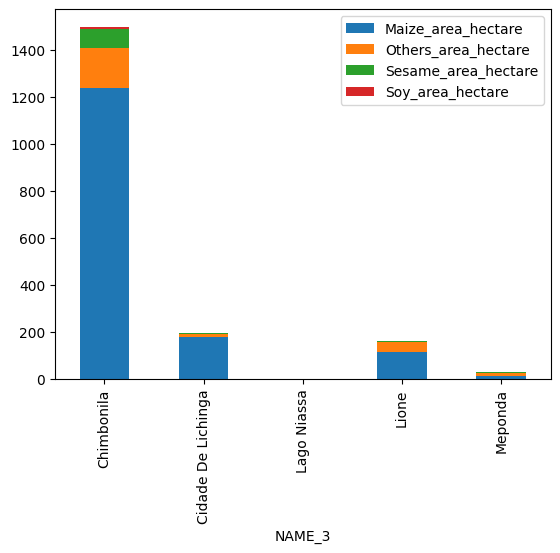

In [95]:
gdf_new[area_columns].set_index(gdf_new[name_col]).plot.bar(stacked=True);

## Export to files

In [97]:
# Set results path
output_folder = "Results/Crop_stats"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [98]:
gdf_new.to_file(os.path.join(output_folder, f"{district_name}_crop_areas.geojson"))

In [99]:
# convert to CSV by dropping geometry
df = pd.DataFrame(gdf_new.drop(columns='geometry'))

df.to_csv(os.path.join(output_folder, f"{district_name}_crop_areas.csv"))